## Project: Object detection
Welcome back guys. Now this is the final step of your course module. Yes this is the application project. We will apply all the learned knowledge in here to create an interesting application based on object detection. We will use the different dataset called football detection dataset.

## Tasks
- Write code to do the following things 
   - visualize with bbox 
   - histogram of number of instances per image
   - histogram of size of the objects 
   - histogram of aspect ratios of the objects 
- train the network for 10 epochs and calculate the mAP 

## Dataset.

The dataset contains snapshot of images from various football matches. All the images are annotated with football using xyxy notation. There are a total of 4177 train images and 764 validation images. Detection of football will allow the video camreas to focus on the ball and the surrondings, allowing us to track the ball movement from time to time and open up new possibilities for calculating various other KPIs, improve video quality, reply analysis and better highlights in the soccer commumity. 

## 1.1 Visualize with bbox
Before starting any machine learning problem, it is good to have proper understanding of the data. In machine vision problems, one get proper understanding of the data by looking into the images and calculating various statistics. In this process visualizing bboxes on the images is very crutial as you want to know what your model is getting trained. The bbox coordinates are shared in different formats (xxyy, xyxy, xyhw, xywh) and sometimes scaled by image height and width etc, so to understand data well, it is always advised to visualize the data first along with coordinates and this is going to be our first task.

Read the train.csv file. select the image_id "72d1210d48a2dd4e" and plot the football labels on the image using draw_grid function available in utils.py.

In [87]:
## Import necessary libraries 
import pandas as pd
from PIL import Image
from utils import draw_grid

## Root location
root = "/mnt/nfshome1/FRACTAL/vanapalli.prakash/Desktop/data/"
imgid = "72d1210d48a2dd4e"

## Read the dataframe
train = pd.read_csv(root+"x_train.csv", header=None)
print(train.shape)

## Select the image bboxs 
bbox = train[train[0] == imgid][[1, 2, 3, 4]].values
print(bbox)

## select the labels 
labels = train[train[0] == imgid][5].values
print(labels)

## Read the image
img_loc = root+"football/"+imgid+".jpg"
img = Image.open(img_loc)

## Draw bouding box on the image
image_with_grid= draw_grid(img.copy(), bbox, labels, outline="red", input_format="xyxy")
image_with_grid

## 1.2 histogram of number of instances per image
How many objects are there per image ? is often the most important question object detection researchers need to ask for them selves. This will let us check if the data is skewed, any outliers etc

Read the train.csv file, count the instances of football for each image and use matplotlib to plot the histogram.

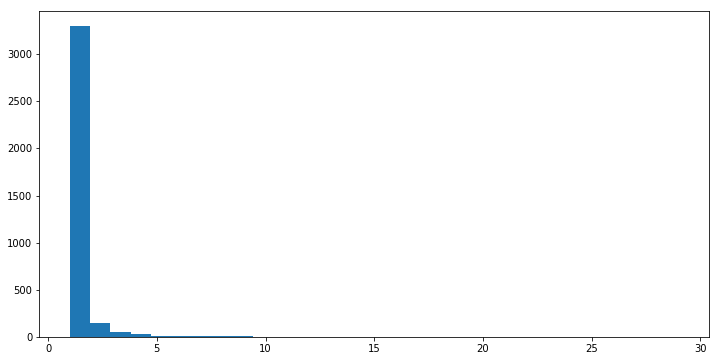

In [91]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

## Root location
root = "/mnt/nfshome1/FRACTAL/vanapalli.prakash/Desktop/data/"

## Read the data
train = pd.read_csv(root+"x_train.csv", header=None)

## take counts of each ImageID
counts = train[0].value_counts().values

## plot using matplotlib
plt.figure(figsize=(12, 6))
plt.hist(counts, bins=30)
plt.show()

## 1.3 histogram of size of the objects
knowing the size of the objects will let us know whether to use FPN and which layers of resnet architecture to use etc. 

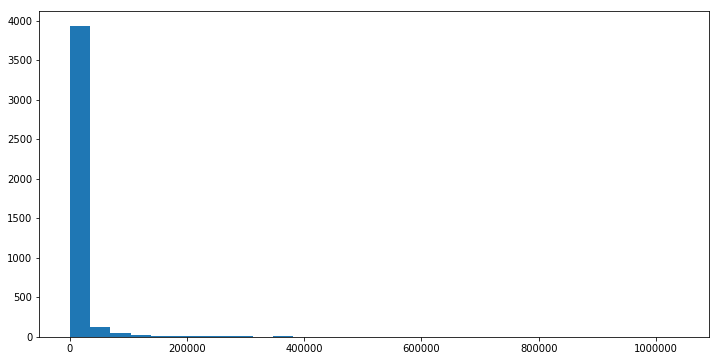

In [97]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

## Root location
root = "/mnt/nfshome1/FRACTAL/vanapalli.prakash/Desktop/data/"

## Read the data
train = pd.read_csv(root+"x_train.csv", header=None)

## calculate area o fthe objects 
size = ((train[3] - train[1]) * (train[4] - train[2])).values

## plot using matplotlib
plt.figure(figsize=(12, 6))
plt.hist(size, bins=30)
plt.show()

## 1.4 histogram of aspect ratios of the objects

Ratios and scales we are using are usually derived from the data. We can check the aspect ratios of your objects and change these values accordingly. For doing so we first need to compute aspect ratios (h/w) of all the objects.

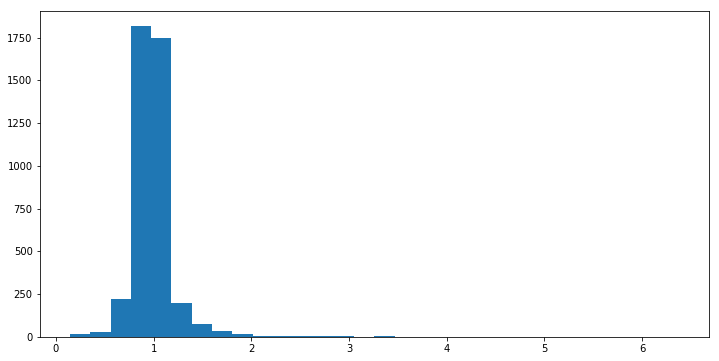

In [100]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

## Root location
root = "/mnt/nfshome1/FRACTAL/vanapalli.prakash/Desktop/data/"

## Read the data
train = pd.read_csv(root+"x_train.csv", header=None)

## calculate area o fthe objects (h/w)
aspect_ratio = ( (train[4] - train[2])/ (train[3] - train[1])).values

## plot using matplotlib
plt.figure(figsize=(12, 6))
plt.hist(aspect_ratio, bins=30)
plt.show()

## 2.1 train the network for 10 epochs and calculate the mAP 
Lets use our 05_practical_101 session in the task. We need to train our football detector. for which we need the following things.

- read train and val files.
- set up the environment and start the session
- load the data generators - we will be using resnet50 as the backend.
- set the image_min_side as 800 and max side as 1333 and use batch_size of 2.
- Load prediction model and training model
- create callbacks for evaluation, schedular and snapshots
- train for 10 epochs. since training images are ~4200 and batch_size is 2. Lets use steps per epoch as 2100( 4200/2).

In [1]:
import pandas as pd 

## Root location
root = "/mnt/nfshome1/FRACTAL/vanapalli.prakash/Desktop/data/"

## Read train and val files
train = pd.read_csv(root+"x_train.csv", header=None)
val = pd.read_csv(root+"x_val.csv", header=None)
print(train.shape, val.shape)

(4177, 6) (764, 6)


In [2]:
train.head()

,0,1,2,3,4,5
0,000067f3419a12fe.jpg,126,526,232,634,football
1,0000c4f95a9d5a54.jpg,601,802,743,942,football
2,0005c78e30d1e388.jpg,194,794,280,871,football
3,0006d33feb26fe48.jpg,699,102,732,133,football
4,0009590f2c11c93d.jpg,428,594,465,629,football


In [3]:
import os 
import tensorflow as tf 
import keras

## using gpu0
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

## start the session
def get_session():
    """ Construct a modified tf session.
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [4]:
from keras_retinanet import models
from keras_retinanet.utils.config import read_config_file
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.preprocessing.csv_generator import CSVGenerator


## Read the config file which contains all the parameters
config = read_config_file(root+"config.ini")
print(config["anchor_parameters"]["ratios"].split(" "))

backbone = models.backbone("resnet50")

batch_size = 2 
image_min_side = 800
image_max_side = 1333 
preprocess_image = backbone.preprocess_image


## start the genertor
transform_generator = random_transform_generator(
            min_rotation=-0.1,
            max_rotation=0.1,
            min_translation=(-0.1, -0.1),
            max_translation=(0.1, 0.1),
            min_shear=-0.1,
            max_shear=0.1,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            flip_y_chance=0.5,
)

train_ann_loc = root+ "x_train.csv"
classes_loc = root+ "class_id.csv"
val_ann_loc = root+ "x_val.csv"
train_generator = CSVGenerator(train_ann_loc,
                               classes_loc,
                               base_dir = root+"football/",
                               transform_generator=transform_generator,
                               batch_size = batch_size, 
                               image_min_side = image_min_side, 
                               image_max_side = image_max_side, 
                               preprocess_image = preprocess_image,
                               config = config)

validation_generator = CSVGenerator(val_ann_loc,
                                    classes_loc,
                                    base_dir = root+"football/",
                                    batch_size = batch_size,
                                    image_min_side = image_min_side, 
                                    image_max_side = image_max_side, 
                                    preprocess_image = preprocess_image,
                                    config = config)

['0.5', '1.', '2.']


In [5]:
from keras_retinanet.utils.config import parse_anchor_parameters
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.bin.train import create_models

## Load the param file
anchor_params = parse_anchor_parameters(config)

## Load the weights file
model_path = "../../weight_files_imp/resnet50_coco_best_v2.1.0.h5"
#weights = backbone.download_imagenet()

## Create models with pretrained weights and other details.
## we are using only 1 gpu, and set the learning rate as 
model, training_model, prediction_model = create_models(
    backbone_retinanet=backbone.retinanet,
    num_classes=train_generator.num_classes(),
    weights=model_path,
    multi_gpu=0,
    freeze_backbone=False,
    lr=1e-5,
    config=config)

Instructions for updating:
Colocations handled automatically by placer.


/mnt/nfshome1/FRACTAL/vanapalli.prakash/miniconda3/envs/keras/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/mnt/nfshome1/FRACTAL/vanapalli.prakash/miniconda3/envs/keras/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))


In [7]:
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.callbacks import RedirectModel

## Initialize the evaluator
evaluation = Evaluate(validation_generator, weighted_average=True)
evaluation = RedirectModel(evaluation, prediction_model)

## Model weights (Create this folder if not present)
snapshot_path = "model_weights/"

if not os.path.exists(snapshot_path):
    os.makedirs(snapshot_path)

# Our dataset type is csv
dataset_type = "csv"

# Define checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
            os.path.join(
                snapshot_path,
                '{backbone}_{dataset_type}_{{epoch:02d}}.h5'.format(backbone=backbone, dataset_type="csv")
            ),
            verbose=1,
            # save_best_only=True,
            # monitor="mAP",
            # mode='max'
        )

# Create checkpoint to store model weights after each epoch
checkpoint = RedirectModel(checkpoint, model)

## create a schedular. We will be using ReduceLRONplateau
sched = keras.callbacks.ReduceLROnPlateau(
        monitor    = 'loss',
        factor     = 0.1,
        patience   = 2,
        verbose    = 1,
        mode       = 'auto',
        min_delta  = 0.0001,
        cooldown   = 0,
        min_lr     = 0
)

## Set all the call backs
callbacks = [evaluation, checkpoint, sched]

In [8]:
## Train for 10 epochs
training_model.fit_generator(
        generator=train_generator,
        steps_per_epoch=2200,
        epochs=10,
        verbose=1,
        callbacks=callbacks,
        workers=8,
        use_multiprocessing=True,
        max_queue_size=10,
        validation_data=validation_generator)

Epoch 1/10
2200/2200 [==============================] - 1296s 589ms/step - loss: 0.9280 - regression_loss: 0.7008 - classification_loss: 0.2272 - val_loss: 0.8157 - val_regression_loss: 0.6702 - val_classification_loss: 0.1455


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:02:43 Time:  0:02:43
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8719
mAP: 0.8719

Epoch 00001: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_01.h5
Epoch 2/10
2200/2200 [==============================] - 969s 441ms/step - loss: 0.7742 - regression_loss: 0.6473 - classification_loss: 0.1269 - val_loss: 0.8019 - val_regression_loss: 0.6776 - val_classification_loss: 0.1243


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8721
mAP: 0.8721

Epoch 00002: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_02.h5
Epoch 3/10
2200/2200 [==============================] - 970s 441ms/step - loss: 0.7371 - regression_loss: 0.6222 - classification_loss: 0.1149 - val_loss: 0.8869 - val_regression_loss: 0.6976 - val_classification_loss: 0.1893


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8741
mAP: 0.8741

Epoch 00003: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_03.h5
Epoch 4/10
 986/2200 [============>.................] - ETA: 8:27 - loss: 0.7125 - regression_loss: 0.6096 - classification_loss: 0.1028764 instances of class football with average precision: 0.8767
mAP: 0.8767

Epoch 00004: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_04.h5
Epoch 5/10
2200/2200 [==============================] - 971s 441ms/step - loss: 0.6695 - regression_loss: 0.5810 - classification_loss: 0.0885 - val_loss: 0.8145 - val_regression_loss: 0.6487 - val_classification_loss: 0.1658


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8791
mAP: 0.8791

Epoch 00005: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_05.h5
Epoch 6/10
2200/2200 [==============================] - 975s 443ms/step - loss: 0.6672 - regression_loss: 0.5807 - classification_loss: 0.0865 - val_loss: 0.9485 - val_regression_loss: 0.6783 - val_classification_loss: 0.2701


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8767
mAP: 0.8767

Epoch 00006: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_06.h5
Epoch 7/10
2200/2200 [==============================] - 971s 441ms/step - loss: 0.6485 - regression_loss: 0.5681 - classification_loss: 0.0805 - val_loss: 0.8563 - val_regression_loss: 0.6825 - val_classification_loss: 0.1739


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:25 Time:  0:01:25
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8750
mAP: 0.8750

Epoch 00007: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_07.h5
Epoch 8/10
2200/2200 [==============================] - 974s 443ms/step - loss: 0.6395 - regression_loss: 0.5636 - classification_loss: 0.0759 - val_loss: 0.8897 - val_regression_loss: 0.6522 - val_classification_loss: 0.2375


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8835
mAP: 0.8835

Epoch 00008: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_08.h5
Epoch 9/10
2200/2200 [==============================] - 971s 442ms/step - loss: 0.6235 - regression_loss: 0.5489 - classification_loss: 0.0746 - val_loss: 0.9073 - val_regression_loss: 0.6703 - val_classification_loss: 0.2370


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8786
mAP: 0.8786

Epoch 00009: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_09.h5
Epoch 10/10
2200/2200 [==============================] - 970s 441ms/step - loss: 0.6199 - regression_loss: 0.5480 - classification_loss: 0.0719 - val_loss: 0.8621 - val_regression_loss: 0.6570 - val_classification_loss: 0.2051


Running network: 100% (629 of 629) |#####| Elapsed Time: 0:01:26 Time:  0:01:26
Parsing annotations: 100% (629 of 629) |#| Elapsed Time: 0:00:00 Time:  0:00:00


764 instances of class football with average precision: 0.8772
mAP: 0.8772

Epoch 00010: saving model to model_weights/<keras_retinanet.models.resnet.ResNetBackbone object at 0x7fa37efcb470>_csv_10.h5
